In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [15]:
import itertools
from collections import defaultdict, Counter
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import jaccard
import scipy.stats as stats

from bgspy.genome import Genome
from bgspy.utils import load_bed_annotation, read_bed3, ranges_to_masks
from bgspy.utils import read_bigwig, load_cadd_bed_scores, read_phastcons
from bgspy.utils import aggregate_site_array, genome_wide_quantiles
from bgspy.utils import bin_chrom, bin_chroms
from bgspy.genome import process_annotation
from bgspy.data import GenomeData

/home/vsb/projects/bprime/bgspy/data.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdm


In [3]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200

## Functions

In [4]:
def annot_summary(annot, seqlens):
    """
    Summarize annotation by chromosome.
    
    Returns (by chromosome) number of features, total bp of 
    features, and fraction of chromosome.    
    """
    annot, all_features = annot
    nfeats = defaultdict(Counter)
    total_bp = defaultdict(Counter)
    frac = defaultdict(Counter)
    lengths = defaultdict(lambda: defaultdict(list))
    for chrom, (ranges, features) in annot.items():
        for (start, end), feature in zip(ranges, features):
            nfeats[chrom][feature] += 1
            total_bp[chrom][feature] += end-start
            lengths[chrom][feature].append(end-start)
    for chrom in total_bp:
        for feature, val in total_bp[chrom].items():
            assert val < seqlens[chrom]
            frac[chrom][feature] = val / seqlens[chrom]
    return nfeats, total_bp, frac, lengths

def annot_merged_summary(annot, genome_length):
    """
    Summarize genome-wide annotation.
    
    Returns number of features, total bp of features, and fraction of genome.
    """
    annot, all_features = annot
    nfeats = Counter()
    total_bp = Counter()
    frac = Counter()
    lengths = defaultdict(list)
    for chrom, (ranges, features) in annot.items():
        for (start, end), feature in zip(ranges, features):
            nfeats[feature] += 1
            total_bp[feature] += end-start
            lengths[feature].append(end-start)

    for feature, val in total_bp.items():
        frac[feature] = val / genome_length
    return nfeats, total_bp, frac, lengths

## Load Genome

In [5]:
hg38_autos = [f"chr{i}" for i in range(1, 23)]

In [6]:
g = Genome('hg38', seqlens_file="../data/annotation/hg38_seqlens.tsv", chroms=hg38_autos)
g.load_recmap("../data/annotation/hapmap_genetic_map.txt")

ignoring HapMap header...
parsing recmap as HapMap formatted (chrom, end, rate)
RecMap._readmap() ignored chrX


In [7]:
hg38_len = sum(v for c, v in g.seqlens.items())
hg38_len/1e9

2.875001522

## Comparison of CADD, PhyloP, and Phastcons


### Notes on the tracks and their scores

#### PhastCons

Type: LRT p-value for conserved status (high odds: more likely generated in conserved state of phylo-HMM).

From [BioStars](https://www.biostars.org/p/9490489/): 
> The conserved elements were predicted by running phastCons with the --viterbi option. The predicted elements are segments of the alignment that are likely to have been "generated" by the conserved state of the phylo-HMM. Each element is assigned a log-odds score equal to its log probability under the conserved model minus its log probability under the non-conserved model. The "score" field associated with this track contains transformed log-odds scores, taking values between 0 and 1. (The scores are transformed using a monotonic function of the form a * log(x) + b.) The raw log odds scores are retained in the "name" field and can be seen on the details page or in the browser when the track's display mode is set to "pack" or "full".

#### PhyloP:

Type: score = -log(p) but positive numbers are conserved, negative are fast-evolving. So conserved segments
are those scores > 0, and we only consider those for tail probabilities, etc.

> In the phyloP plots, sites predicted to be conserved are assigned positive scores (and shown in blue), while sites predicted to be fast-evolving are assigned negative scores (and shown in red).


#### CADD

> They summarize the extent to which the variant is likely to have derived from the proxy-neutral (negative values) or proxy-deleterious (positive values) class. Because they have no absolute meaning, they cannot be directly compared across models with distinct annotation combi- nations, training sets or tuning parameter choices. 'PHRED-scaled' scores are normalized to all potential ∼ 9 billion SNVs, and thereby provide an externally compara- ble unit for analysis.

### Fraction of the Genome in Various Annotations

What fraction of the autosomal genome do various strongly conserved annotations occupy? 

In [98]:
beds = {
    # what McVicker et al use:
    'phastcons': '../data/annotation/conserved_phastcons.bed.gz',

    'cds+phastcons':              '../data/annotation/conserved_cds_phastcons.bed.gz',
    'cds+utrs':                   '../data/annotation/conserved_cds_utrs.bed.gz',
    'cds+utrs+phastcons':         '../data/annotation/conserved_cds_utrs_phastcons.bed.gz',
    'cds+utrs+introns':           '../data/annotation/conserved_cds_utrs_introns.bed.gz',
    'cds+utrs+introns+phastcons': '../data/annotation/conserved_cds_utrs_introns_phastcons.bed.gz',
    'cds+utrs+promoters':         '../data/annotation/conserved_cds_utrs_promoters2kb.bed.gz'
}

In [99]:
def calc_bed_coverage(f, seqlens):
    bed = read_bed3(f, g.seqlens)
    return sum([e-s for s, e in itertools.chain(*bed.values())]) / sum(seqlens.values())

In [100]:
annot_coverage = {k: np.round(calc_bed_coverage(f, g.seqlens), 4) for k, f in beds.items()}

In [101]:
annot_coverage

{'phastcons': 0.0508,
 'cds+phastcons': 0.0548,
 'cds+utrs+phastcons': 0.0687,
 'cds+utrs+introns': 0.4229,
 'cds+utrs+introns+phastcons': 0.4454,
 'cds+utrs+promoters': 0.0568}

#### Load CADD, PhyloP, PhastCons, and Genomic Element Tracks

In [12]:
# created in the annotation Snakefile
cadd = np.load('../data/annotation/cadd_whole_genome_SNVs.npz')

In [102]:
# bed file annotation to bp (e.g. not CADD and phylop)
annot = {c: ranges_to_masks(read_bed3(f), g.seqlens) for c, f in beds.items()}

/home/vsb/projects/bprime/bgspy/utils.py:765: UserWarning: sequence chrX not in dictionary seqlens, skipping...
  warnings.warn(f"sequence {chrom} not in dictionary seqlens, skipping...")


In [14]:
# created in the annotation Snakefile
phylop = np.load('../data/annotation/hg38.phyloP30way.npz')

### Phastcons, PhyloP, and CADD top regions comparison

In [16]:
alpha = 0.06
cadd_thresh, cadd_phred_samples = genome_wide_quantiles(cadd, 1-alpha, subsample_chrom=0.001, return_samples=True)

In [17]:
phylop_thresh, _ = genome_wide_quantiles(phylop, 1-alpha, subsample_chrom=0.001, return_samples=True)

In [18]:
gd = GenomeData(g)
gd.load_accessibile_masks('../data/annotation/no_centro.bed')
gd.load_fasta('../data/annotation/hg38.fa.gz')

In [115]:
annots = ['phastcons', 'cds+phastcons', 'cds+utrs+phastcons', 'cds+utrs+promoters']

gd.counts = dict()
for chrom in gd.chroms:
    M = [cadd[chrom] > cadd_thresh,
         phylop[chrom] > phylop_thresh]
    for type in annots:
        M.append(annot[type][chrom])
         
    gd.counts[chrom] = np.stack(M).T
gd.labels = ['cadd', 'phylop'] + annots

In [ ]:
cons_bins_100kb = gd.bin_data(1e5, func=lambda x: np.nanmean(x, axis=0))

In [ ]:
cons_bins_1Mb = gd.bin_data(1e6, func=lambda x: np.nanmean(x, axis=0))

In [ ]:
cons_bins_1Mb.data_['chr1'].shape

ValueError: label must be scalar or have the same length as the input data, but found 4 for 6 datasets.

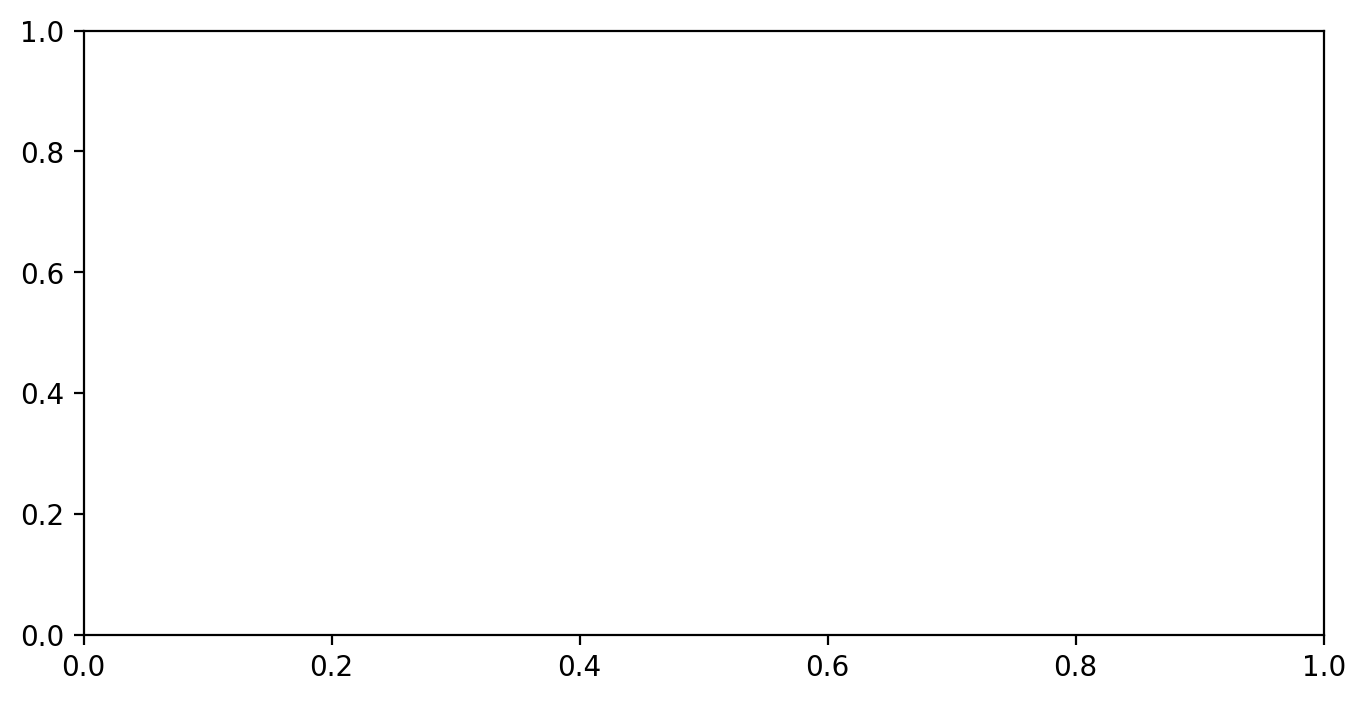

In [109]:
plt.plot(*cons_bins_1Mb.pairs('chr1'), alpha=0.9, linewidth=0.8, label=cons_bins_1Mb.labels)
plt.legend()

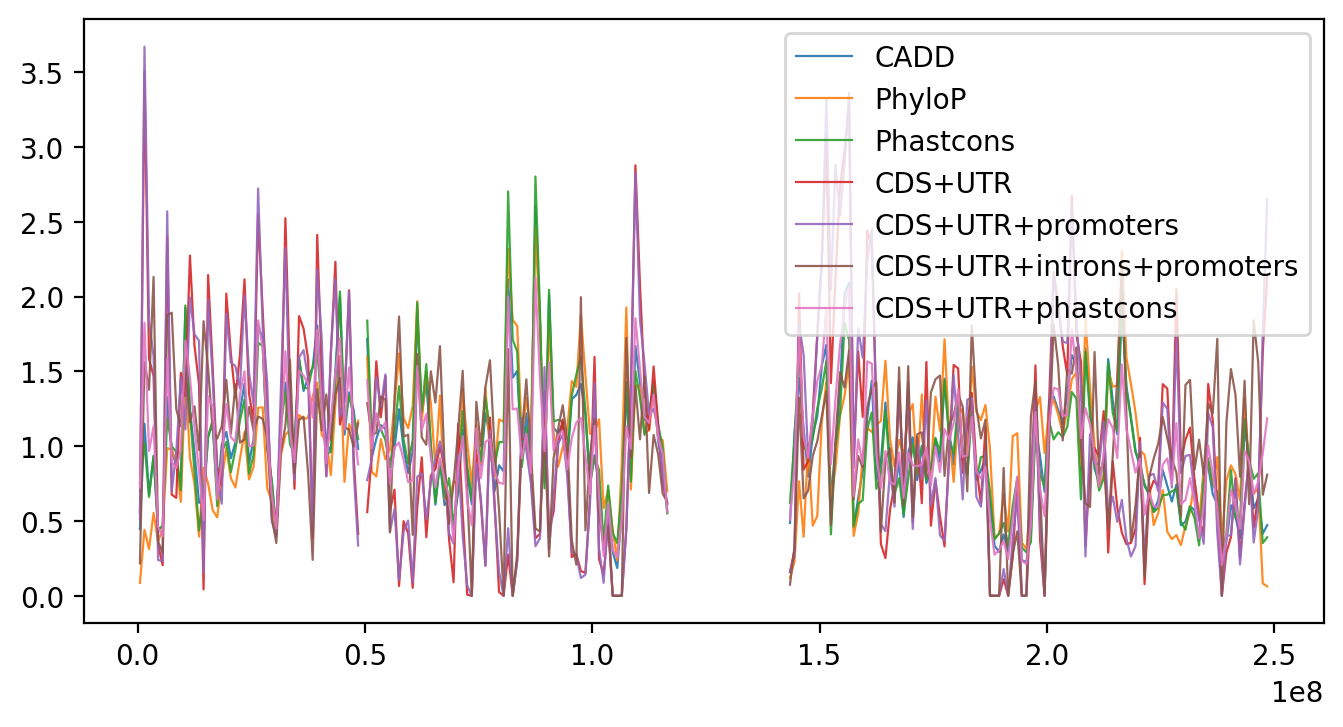

In [93]:
x, y = cons_bins_1Mb.pairs('chr1')
plt.plot(x, (y / np.nanmean(y, axis=0)), alpha=0.9, linewidth=0.8, label=cons_bins_1Mb.labels)
plt.legend()

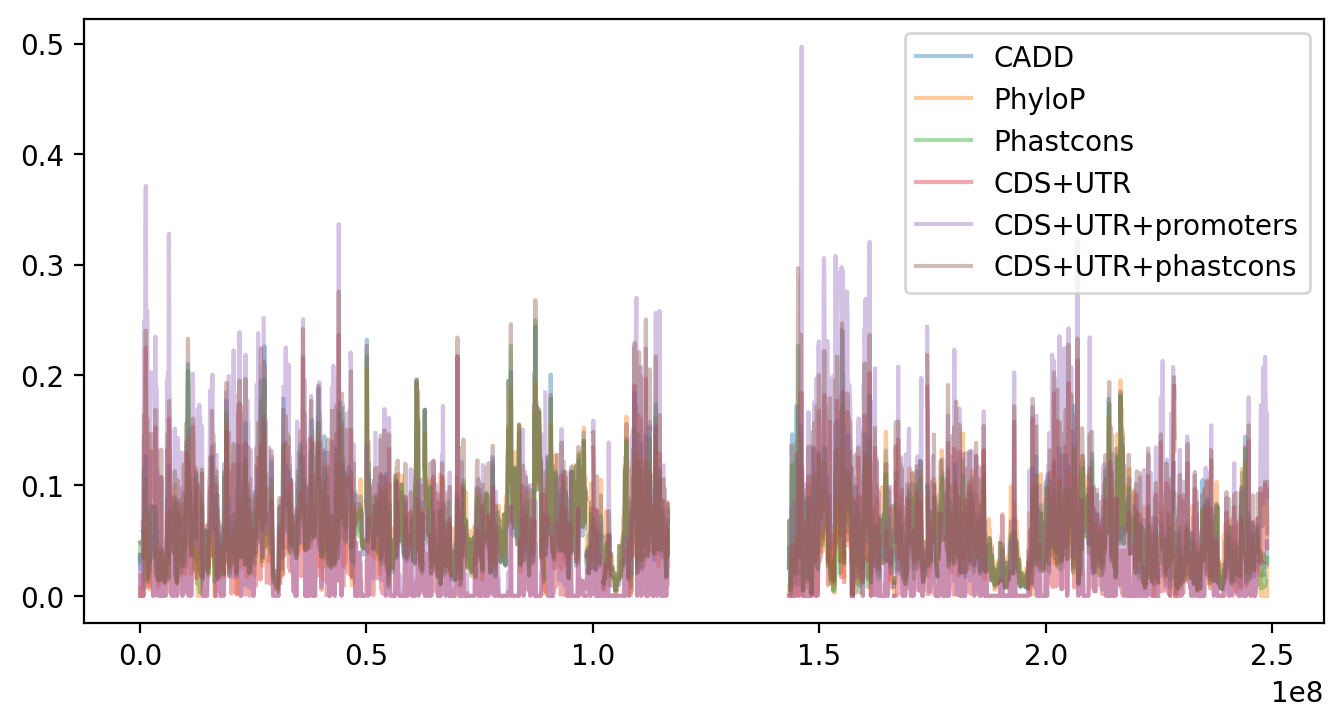

In [64]:
plt.plot(*cons_bins_100kb.pairs('chr1'), alpha=0.4, label=cons_bins_100kb.labels)
plt.legend()

## Old stuff below

In [ ]:
bb

In [ ]:
plt.plot(*bb.pairs('chr17'))

In [212]:
gd1 = GenomeData(g)
gd1.counts = {c: x[:, None] for c, x in cadd.items()}
bb1 = gd1.bin_data(1e5, func=lambda x: np.nanmean(x > 12, axis=0))

  0%|          | 0/22 [00:00<?, ?it/s]

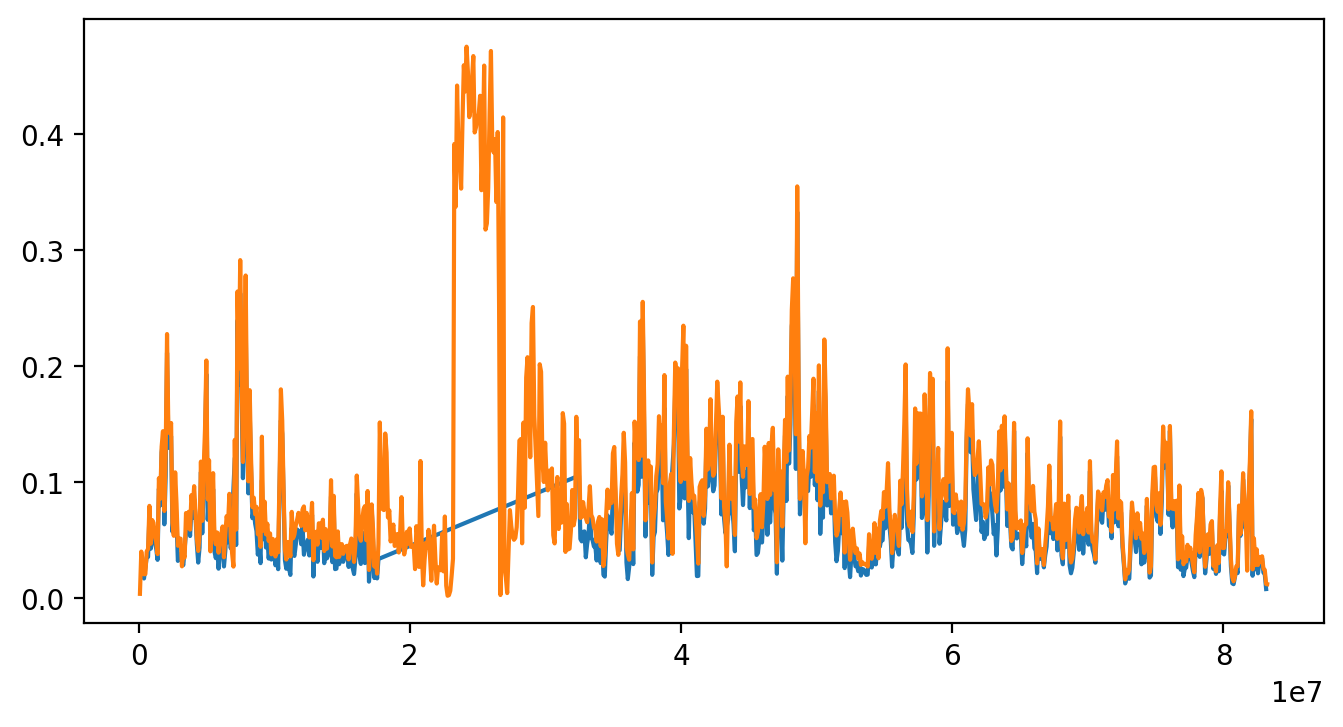

In [213]:
plt.plot(*bb.pairs('chr17', filter_masked=True))
plt.plot(*bb1.pairs('chr17', filter_masked=True))

In [138]:
gbins = GenomicBinnedData(g.seqlens, 100000)
gbins.mask_accessible(g)
gbins.aggregate_site_data(cadd, func=np.nanmean)

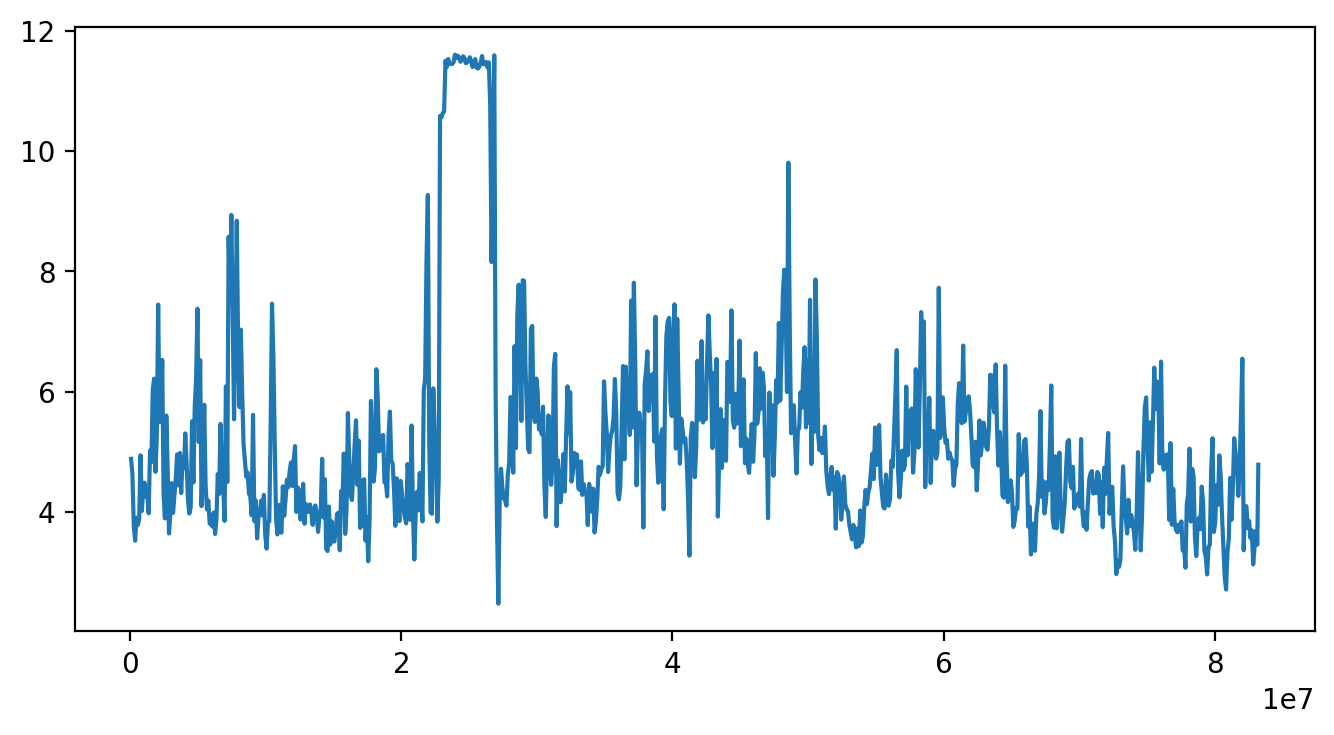

In [145]:
plt.plot(*gbins.pairs('chr17'))

In [121]:
chr1_bins = bin_chrom(g.seqlens['chr1'], 1e6)
pc = aggregate_site_array(~np.isnan(phastcons['chr1'])[:, None], chr1_bins, np.mean)

In [122]:
alpha = 0.06
thresh = np.nanquantile(cadd['chr1'], 1-alpha)
cd = aggregate_site_array((cadd['chr1'] > thresh)[:, None], chr1_bins, np.mean)

In [123]:
pp_thresh = np.nanquantile(phylop['chr1'], 1-alpha)
pp = aggregate_site_array((phylop['chr1'] >= pp_thresh)[:, None], chr1_bins, np.mean)

(-0.05, 0.25)

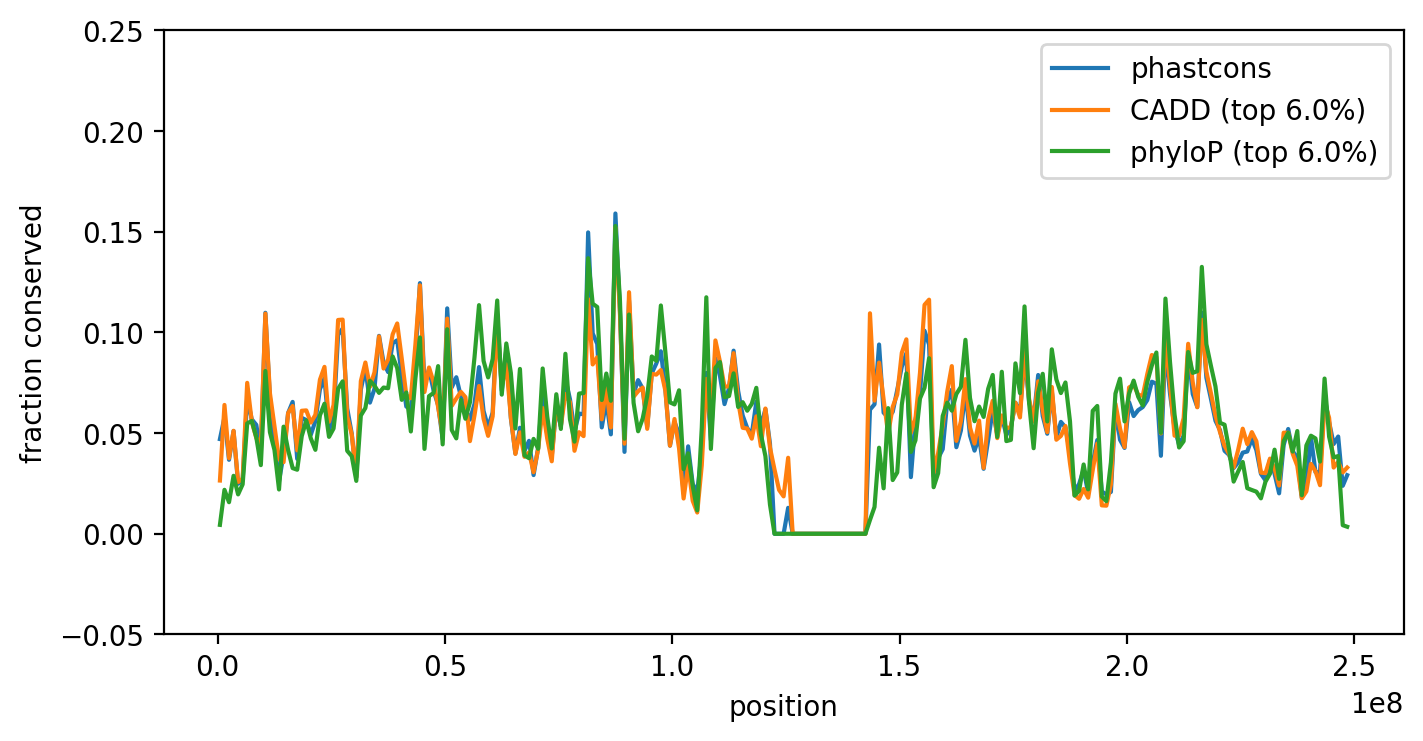

In [124]:
fig, ax = plt.subplots()
ax.plot(*pc.pairs, label='phastcons')
ax.plot(*cd.pairs, label=f'CADD (top {alpha*100}%)')
ax.plot(*pp.pairs, label=f'phyloP (top {alpha*100}%)')
ax.legend()
ax.set_xlabel("position")
ax.set_ylabel("fraction conserved")
ax.set_ylim(-0.05, 0.25)

To compare, we need to use the top $\alpha$% of different tracks.

In [62]:
cutoff, cadd_phred_samples = genome_wide_quantiles(cadd, 1-0.06, subsample_chrom=0.001, return_samples=True)

In [63]:
cutoff

12.600000381469727

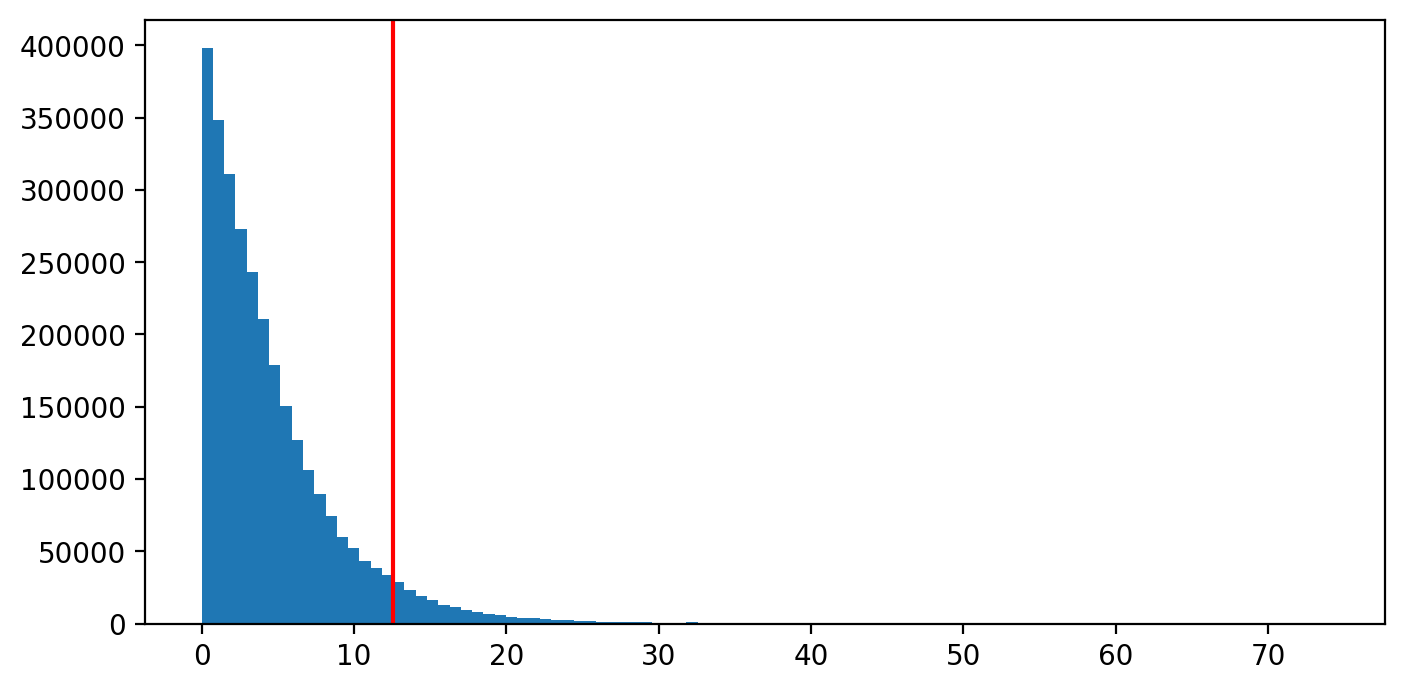

In [64]:
_ = plt.hist(cadd_phred_samples, 100)
plt.axvline(cutoff, c='r')

In [65]:
cadd_top = cadd['chr1'] > cutoff

For our complete-coverage CADD track, we use the following quantiles:

In [43]:
cadd_quantiles = np.sort(1-np.array([0, 0.02, 0.06, 0.1, 0.2, 1]))
cadd_quantiles

array([0.  , 0.8 , 0.9 , 0.94, 0.98, 1.  ])

In [45]:
phylop = read_bigwig('../data/annotation/hg38.phyloP30way.bw', {'chr1': g.seqlens['chr1']})

In [50]:
phylop_thresh = np.nanquantile(phylop['chr1'], 1-0.06)

In [56]:
phylop_top = phylop['chr1'] > phylop_thresh

In [54]:
phylop['chr1']

array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)

In [96]:
def coverage_stats(x, y):
    complete = np.logical_and(~np.isnan(x), ~np.isnan(y))
    x, y = x[complete], y[complete]
    overlaps = np.logical_and(x, y)
    neither = np.logical_and(~x, ~y)
    either = np.logical_or(x, y)
    x_not_y = np.logical_and(x, ~y)
    y_not_x = np.logical_and(~x, y)
    return np.nansum(overlaps), np.nansum(neither), np.nansum(either), np.nansum(x_not_y), np.nansum(y_not_x)
    #return np.nanmean(overlaps), np.nanmean(either), np.nanmean(x_not_y), np.nanmean(y_not_x)
    return 1-jaccard(x, y), np.nansum(overlaps) / np.nansum(either)

In [112]:
bin_chroms(g.seqlens, 10000)

{'chr1': array([        0,     10000,     20000, ..., 248940000, 248950000,
        248956422], dtype=uint32),
 'chr2': array([        0,     10000,     20000, ..., 242180000, 242190000,
        242193529], dtype=uint32),
 'chr3': array([        0,     10000,     20000, ..., 198280000, 198290000,
        198295559], dtype=uint32),
 'chr4': array([        0,     10000,     20000, ..., 190200000, 190210000,
        190214555], dtype=uint32),
 'chr5': array([        0,     10000,     20000, ..., 181520000, 181530000,
        181538259], dtype=uint32),
 'chr6': array([        0,     10000,     20000, ..., 170790000, 170800000,
        170805979], dtype=uint32),
 'chr7': array([        0,     10000,     20000, ..., 159330000, 159340000,
        159345973], dtype=uint32),
 'chr8': array([        0,     10000,     20000, ..., 145120000, 145130000,
        145138636], dtype=uint32),
 'chr9': array([        0,     10000,     20000, ..., 138380000, 138390000,
        138394717], dtype=uint32),
 

In [113]:
1-jaccard(cadd_top, cds_utrs_phastcons_masks['chr1'])

0.4014586417384084

In [114]:
1-jaccard(cadd_top, phylop_top)

0.19352296395830126

In [98]:
4858717 / 25106669

0.1935229639583013

In [70]:
1-jaccard(cadd_top, np.random.permutation(phylop_top))

0.03060689358963542

In [71]:
1-jaccard(cadd_top, phylop_top)

0.19352296395830126

In [72]:
phastcons = read_phastcons('../data/annotation/phastConsElements100way.txt.gz', {'chr1': g.seqlens['chr1']})

In [77]:
1-jaccard(cadd_top, ~np.isnan(phastcons['chr1']))

0.4436288495358298

What's the correlation between phastcons score and CADD score? it's messy but there's a slight relationship. Generally I've found phastcons scores are not particularly meaninful.

Text(0.5, 0, 'CADD (Phred Score)')

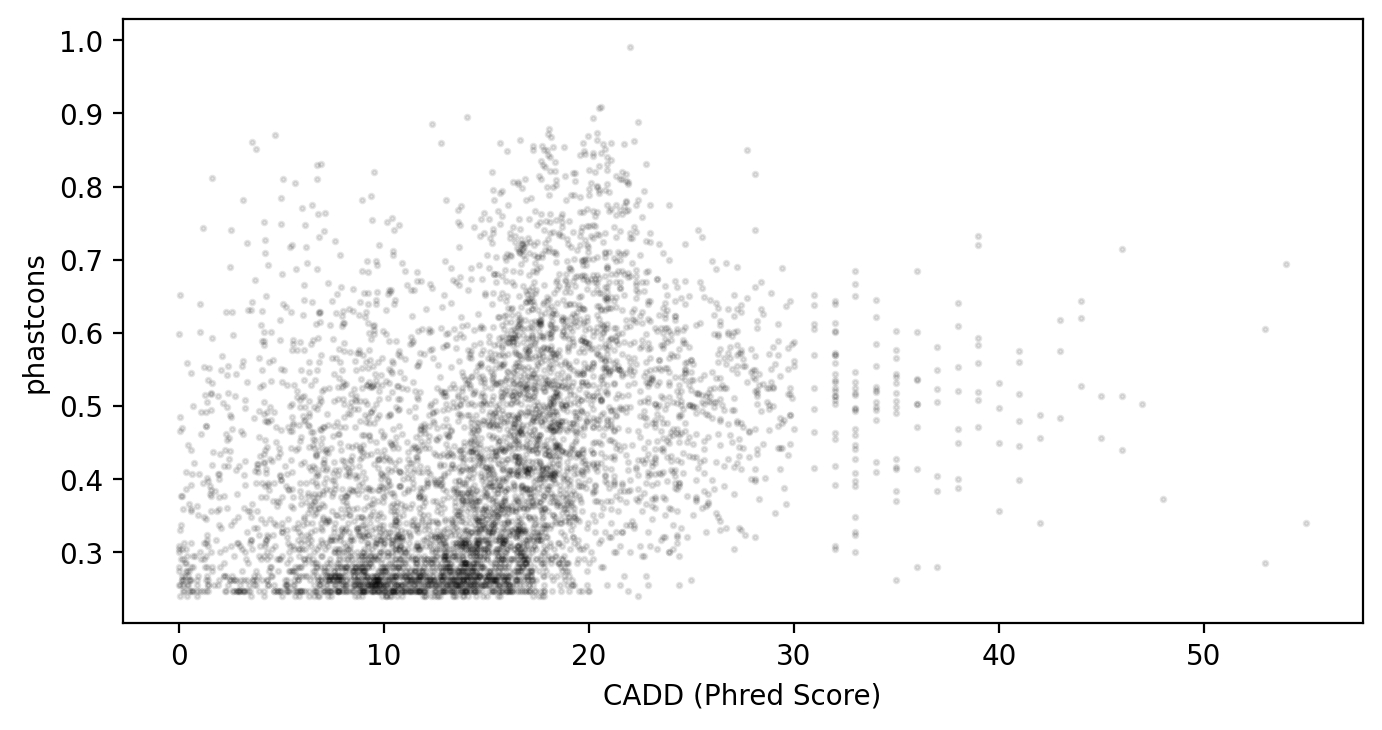

In [13]:
idx = np.random.randint(0, g.seqlens['chr1'], 100000)
plt.scatter(cadd['chr1'][idx], phastcons['chr1'][idx], c='k', alpha=0.1, s=3)
plt.ylabel("phastcons")
plt.xlabel("CADD (Phred Score)")
#plt.semilogx()

In [58]:
thresh = np.nanquantile(cadd['chr1'], 1-alpha)
pc_top = ~np.isnan(phastcons['chr1'])
cd_top = cadd['chr1'] > thresh

NameError: name 'alpha' is not defined

In [55]:
1-jaccard(cd_top, np.random.permutation(pc_top))

NameError: name 'cd_top' is not defined

In [61]:
def phylop_conserved_mask(x, quantile=0.05):
    """
    Mark basepairs that are conserved according to a PhyloP
    track (including accelerated and conserved segments), if
    the p-value is in the specified quantile (of conserved only)
    """
    out = dict()
    
    thresh = np.nanquantile([np.exp(-x) for x in itertools.chain(*x.values()) if x > 0], quantile)
    
    for chrom, scores in x.items():
        # conserved are positive, s = -log(p), p = exp(-s)
        pval = np.exp(-np.abs(scores))
        out[chrom] = (scores > 0) & (pval <= thresh)
    return out



xx = phylop_conserved_mask(phylop)

In [63]:
xx['chr1'].mean()

0.029244383179639368

In [65]:
jaccard(xx['chr1'], cadd['chr1'])

KeyboardInterrupt: 

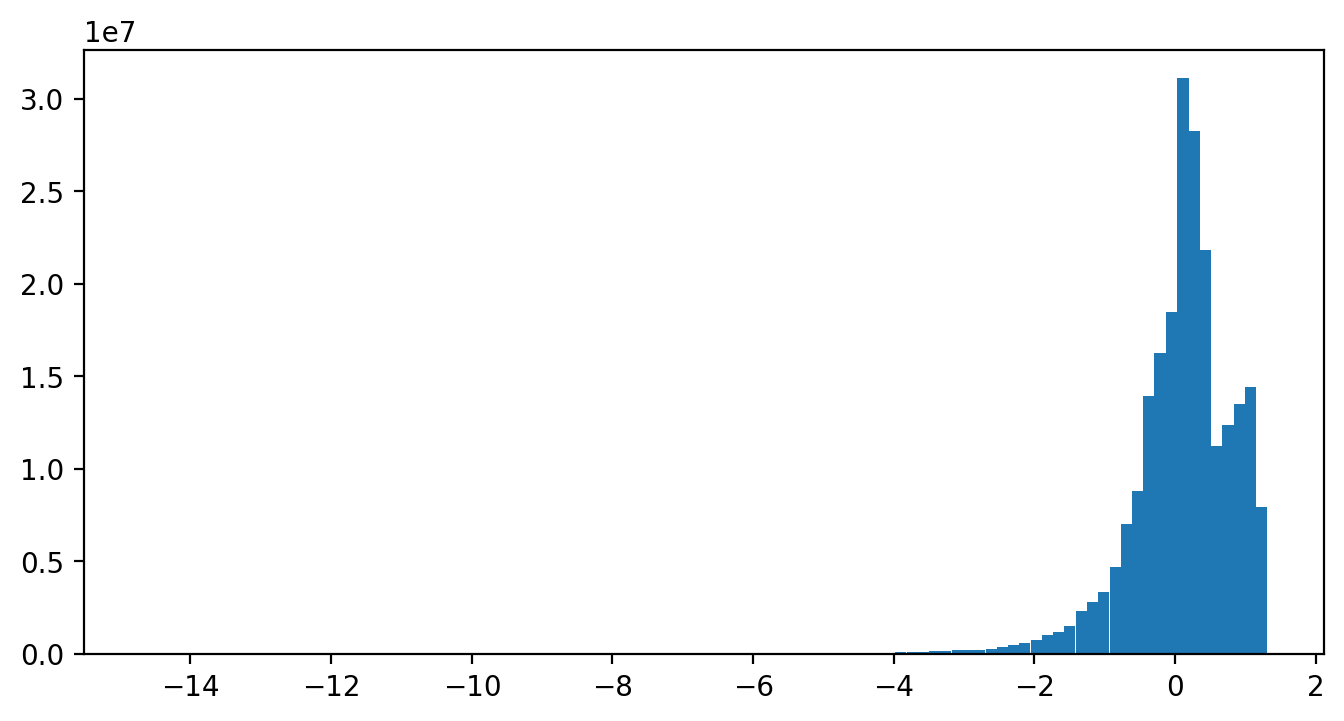

In [89]:
_ = plt.hist(phylop['chr1'], 100)

In [82]:
from bgspy.utils import aggregate_site_array, bin_chrom

tt = aggregate_site_array(a[:, None], bin_chrom(g.seqlens['chr1'], 1e5), np.nanmean)

/home/vsb/projects/bprime/bgspy/utils.py:397: RuntimeWarning: Mean of empty slice
  vals[i-1, ...] = func(data_in_bin, **kwargs)


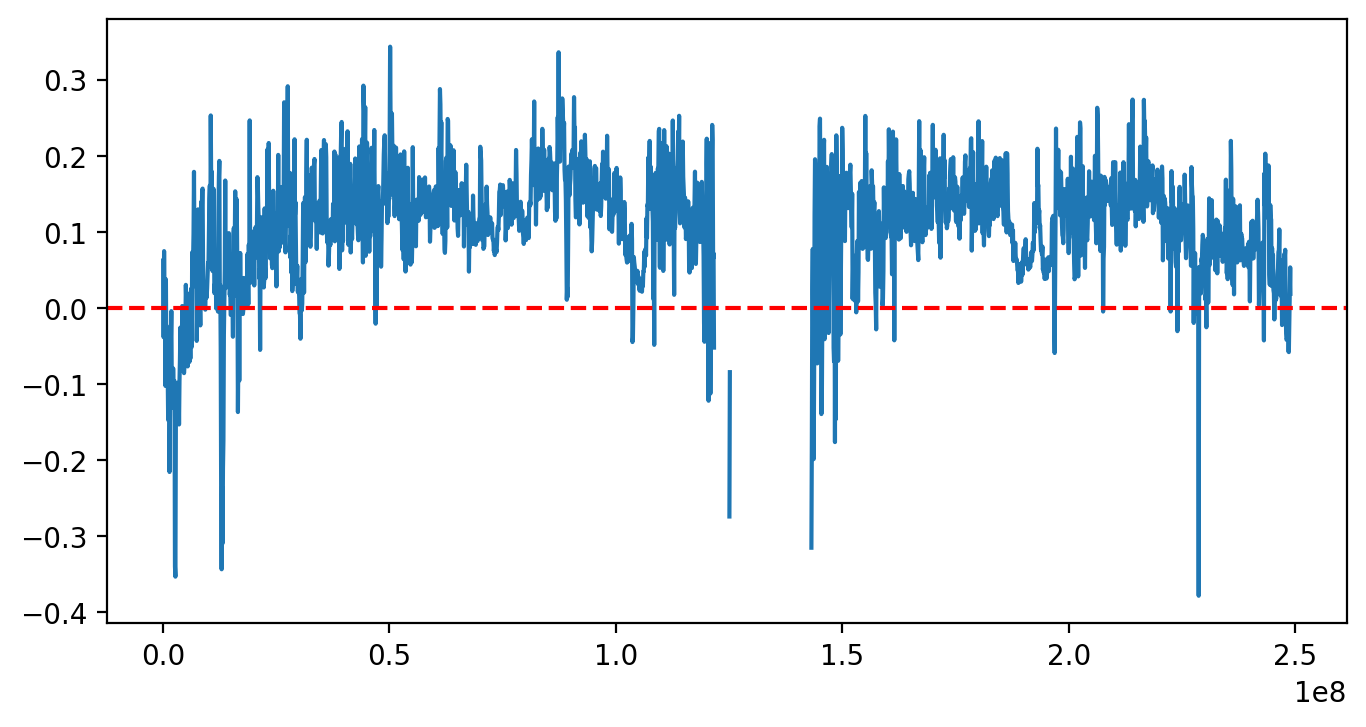

In [83]:
plt.plot(tt.bins[1:], tt.stat)
plt.axhline(0, linestyle='dashed', c='r')

In [64]:
from bgspy.utils import read_cadd

In [74]:
cadd = read_cadd('../data/annotation/cadd_whole_genome_SNVs.tsv.gz', {'chr1': g.seqlens['chr1']})

In [75]:
np.nansum(cadd['chr1'])

/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


inf

(array([2.00000000e+00, 2.00000000e+00, 0.00000000e+00, 4.74000000e+02,
        2.25227019e+08, 5.05132200e+06, 1.95772000e+05, 6.39300000e+03,
        2.50000000e+01, 3.00000000e+00]),
 array([-17.38 , -13.555,  -9.734,  -5.914,  -2.094,   1.727,   5.547,
          9.37 ,  13.19 ,  17.   ,  20.83 ], dtype=float16),
 <BarContainer object of 10 artists>)

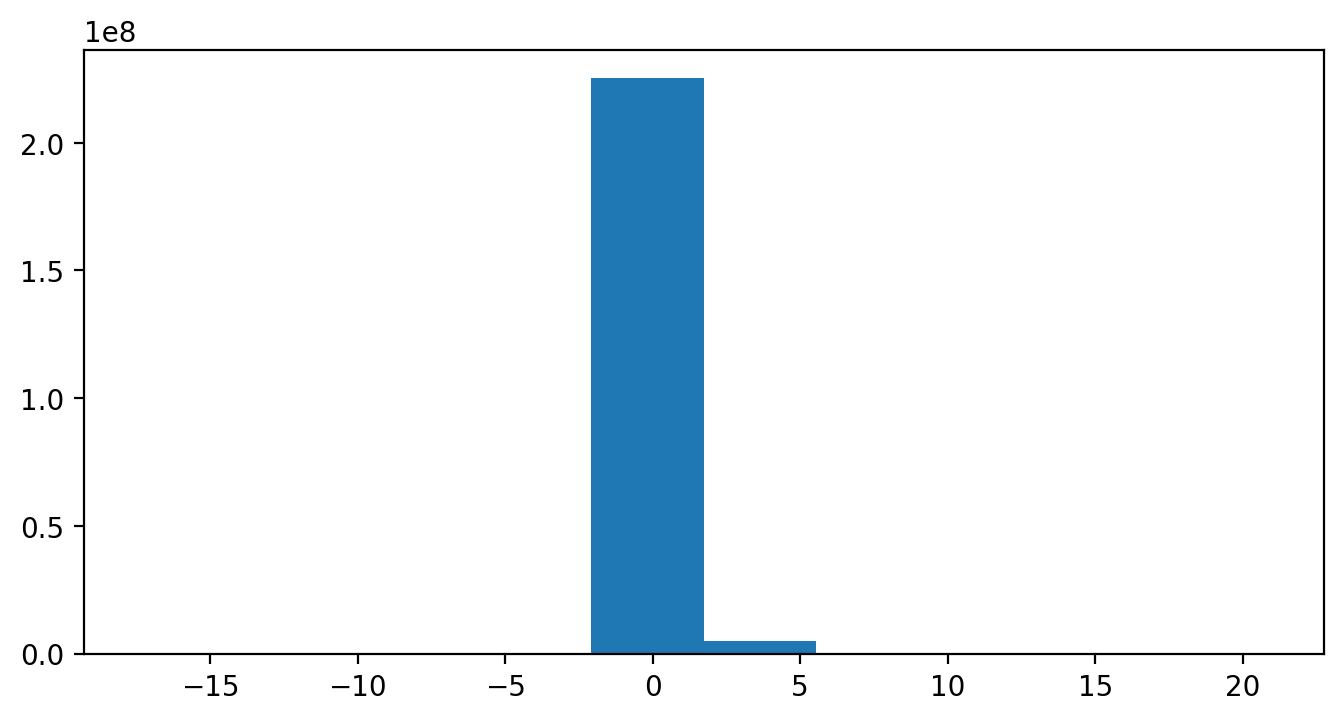

In [76]:
x = cadd['chr1']

plt.hist(x[~np.isnan(x)])

## Recombination

To validate the recombination map (and all our interpolators, etc) I downloaded a human hg38 recombination map mentionedin [this thread](https://github.com/statgen/locuszoom-standalone/issues/1), used by LocusZoom. It has cummulative map positions, which is a good way to validate our interpolation.

Note that during validation, I found that quadratic interpolation was leading to some very odd results, so it's best to use linear. 

In [8]:
g.recmap

RecMap('../data/annotation/hapmap_genetic_map.txt')
 total length: 37.31 Morgans

This total map length (including X) is in line with the total map length published by [Broman et al. (1998)](https://pubmed.ncbi.nlm.nih.gov/9718341/).

In [42]:
d = pd.read_csv('../data/annotation/recomb-hg38/genetic_map_GRCh38_merged.tab', sep='\t')

In [43]:
d.head()

,chrom,pos,recomb_rate,pos_cm
0,chr10,48232,0.1614,0.002664
1,chr10,48486,0.1589,0.002705
2,chr10,50009,0.1590,0.002947
3,chr10,52147,0.1574,0.003287
4,chr10,52541,0.1592,0.003349


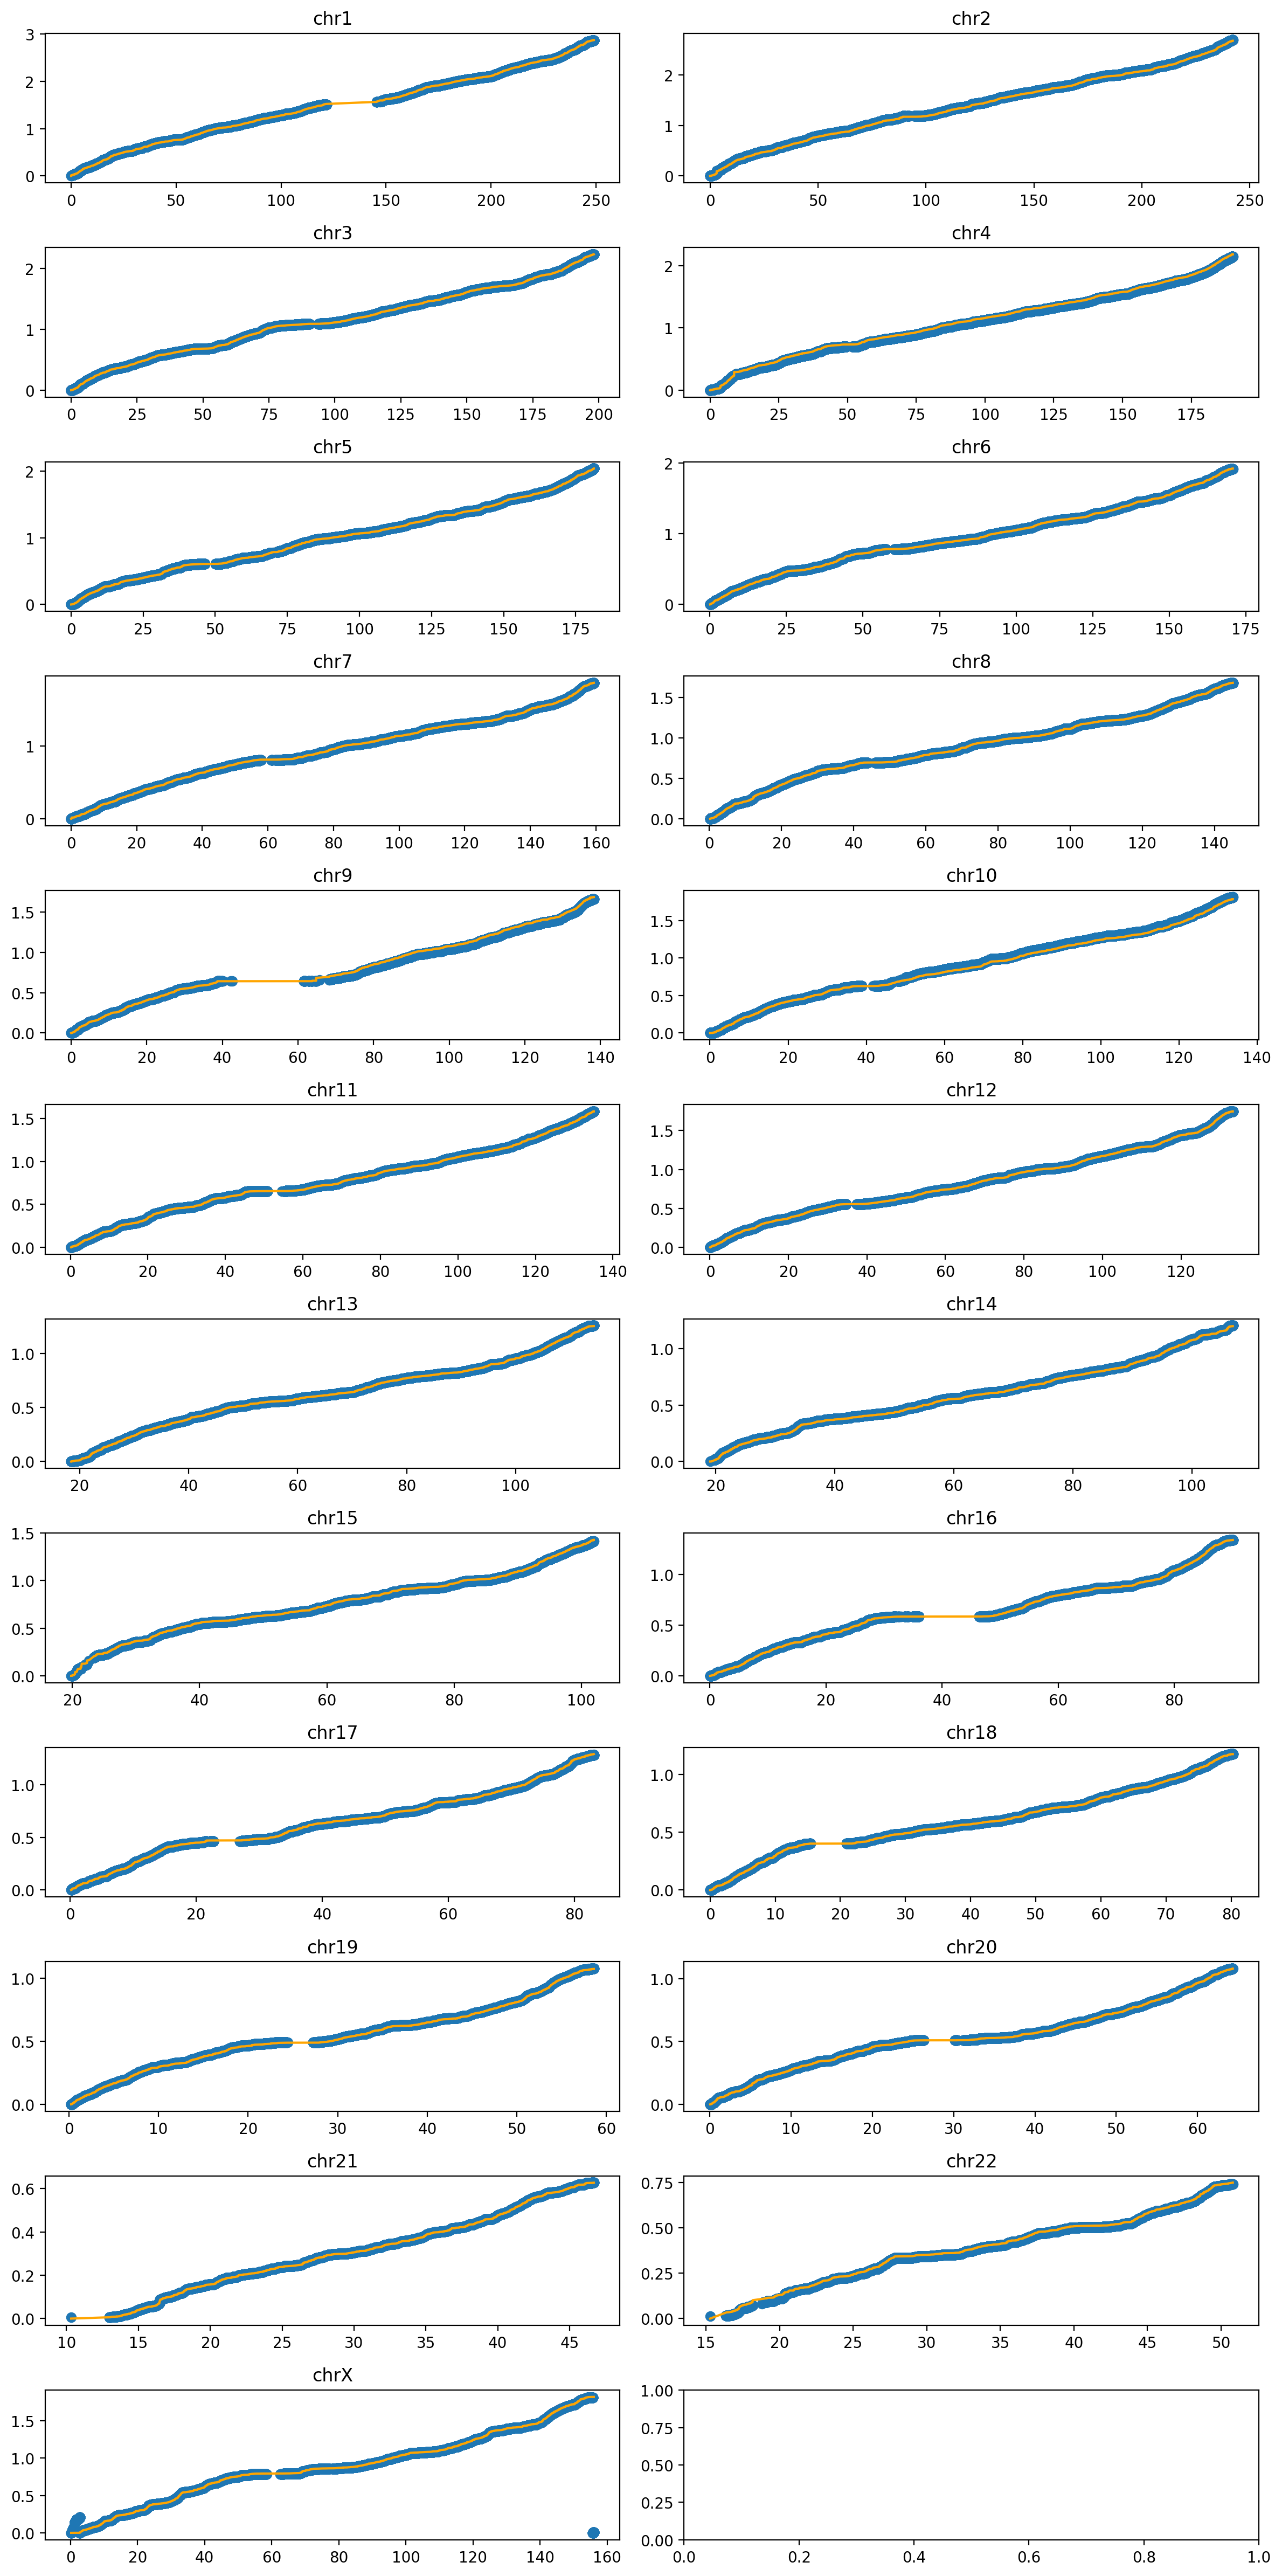

In [45]:

grid = list(itertools.product(range(12), range(2)))

fig, axs = plt.subplots(ncols=2, nrows=12, figsize=(12, 24))

for i, chrom in enumerate(g.chroms):
    ii, jj = grid[i]
    ax = axs[ii, jj] 
    d_chr = d.loc[d.chrom == chrom]
    pos = np.unique(d_chr.pos)
    y = g.recmap.lookup(chrom, pos, cummulative=True)
    ax.plot(pos/1e6, y, label='linear interpolated', c='orange')
    ax.scatter(d_chr['pos']/1e6, d_chr['pos_cm']/100, label='alt map')
    #ax.set_ylabel('cummulative map position (Morgans)')
    #ax.set_xlabel('position')
    ax.set_title(chrom)

plt.tight_layout()

Same as above, but with randomly selected sites to interpolate -- this is a test of the interpolation function. 

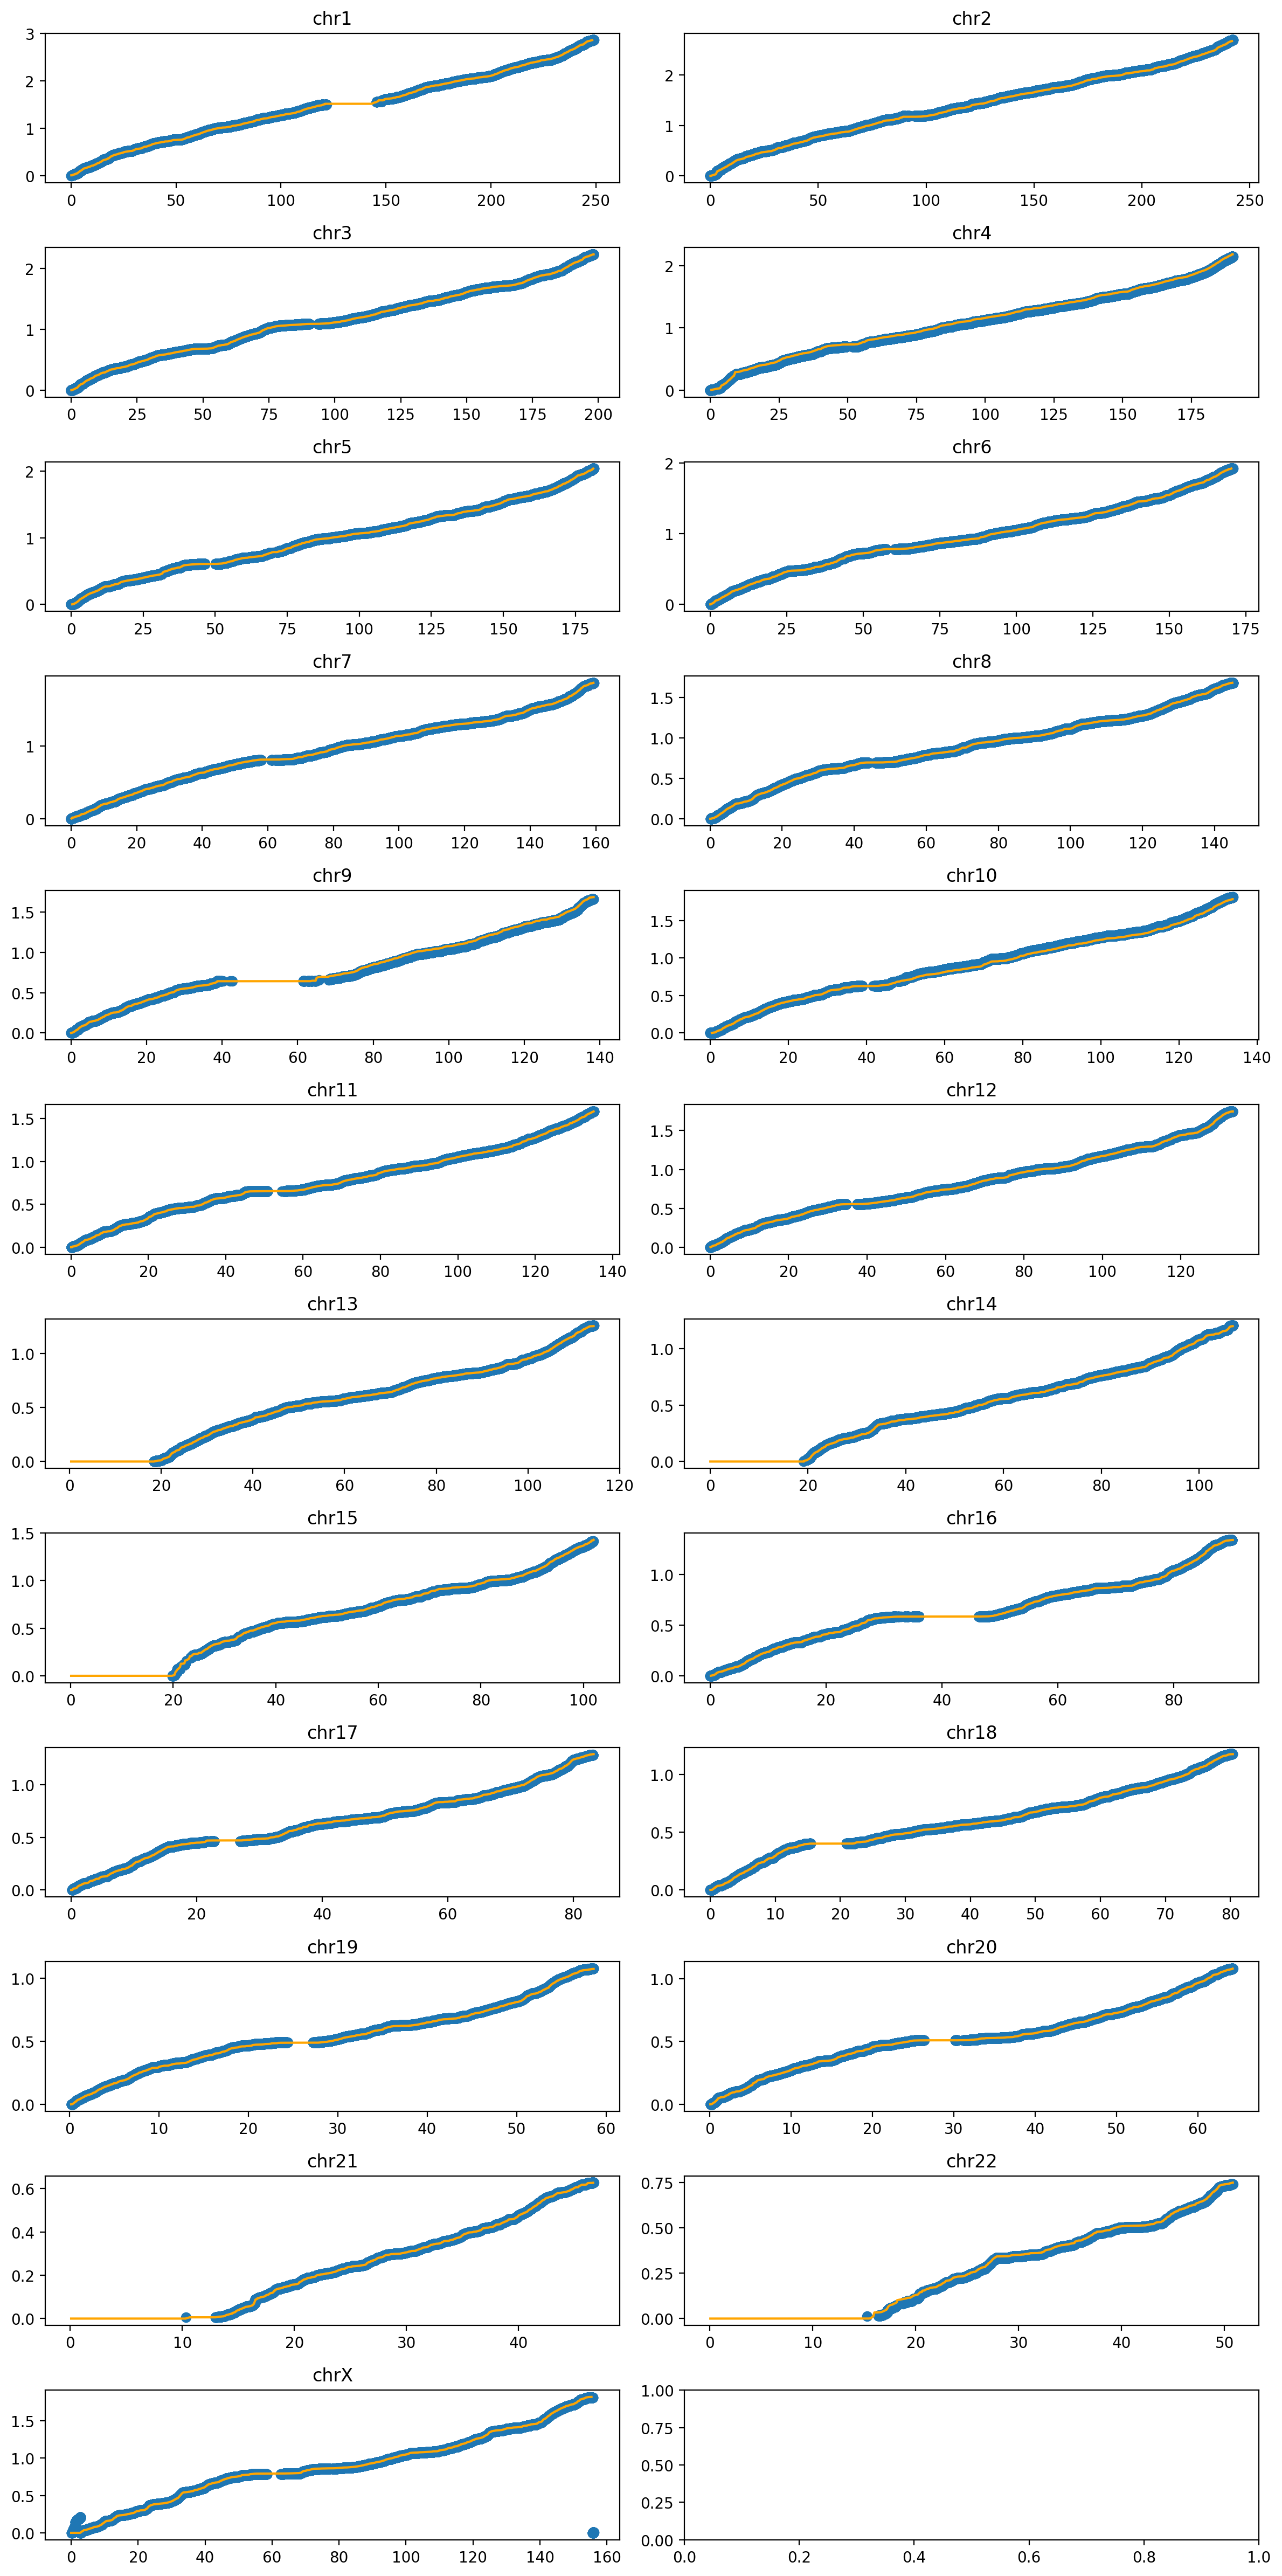

In [12]:

grid = list(itertools.product(range(12), range(2)))

fig, axs = plt.subplots(ncols=2, nrows=12, figsize=(12, 24))

for i, chrom in enumerate(g.chroms):
    ii, jj = grid[i]
    ax = axs[ii, jj] 
    d_chr = d.loc[d.chrom == chrom]
    pos = np.sort(np.random.randint(0, g.seqlens[chrom], 1000))
    y = g.recmap.lookup(chrom, pos, cummulative=True)
    ax.scatter(d_chr['pos']/1e6, d_chr['pos_cm']/100, label='alt map')
    ax.plot(pos/1e6, y, label='linear interpolated', c='orange')    
    #ax.set_ylabel('cummulative map position (Morgans)')
    #ax.set_xlabel('position')
    ax.set_title(chrom)

plt.tight_layout()

## Annotation Tracks

We need basic statistics on the conserved annotation tracks — their composition etc.

### Merged Track

This is a merged track with CDS, UTRs, introns, and phastcons ranges. The directions to create it are in the `../data/annotation/Snakefile`. The merging rules follow the priority:

```
CDS > introns > UTRs > phastcons
```

meaning that any overlapping range with a CDS is classified as CDS, any intron UTR overlap is classified as intron, etc. Phastcons has the lowest priority.

In [46]:
merged_annot = load_bed_annotation('../data/annotation/conserved_cds_utrs_introns_phastcons.bed.gz')

In [47]:
merged_summary = annot_merged_summary(merged_annot, hg38_len)

In [48]:
# number of features
merged_summary[0]

Counter({'phastcons': 3672949, 'utr': 86319, 'intron': 239357, 'cds': 212056})

In [49]:
# proportion of total genome
merged_summary[2]

Counter({'phastcons': 0.022488878181539967,
         'utr': 0.017523136114708463,
         'intron': 0.41097623669362354,
         'cds': 0.012388024746235248})

This are roughly the proportions we expect: CDS ~2%, and introns are ~40%.

In [50]:
merged_summary_chrom = annot_summary(merged_annot, g.seqlens)

In [51]:
# inspect one chromosome
merged_summary_chrom[2]['chr1']

Counter({'phastcons': 0.021450585436193326,
         'utr': 0.02051145722201936,
         'intron': 0.41069157476885654,
         'cds': 0.0144966093704544})

Now let's load in in the segments into the `Segments` object that will be used to calculate B and make sure that these results match up with the raw annotation files (in the future this could be a unit test).

In [53]:
g.load_annot('../data/annotation/conserved_cds_utrs_introns_phastcons.bed.gz')
g.load_recmap('../data/annotation/hapmap_genetic_map.txt')
g.create_segments()

ignoring HapMap header...
parsing recmap as HapMap formatted (chrom, end, rate)


KeyboardInterrupt: 

In [ ]:
stats = g.feature_stats(exclude_chroms=['X'])
stats

In [ ]:
# now, let's compare these segment statistics from those from the merged annotation file directly
stats_chrom = g.feature_stats(by_chrom=True, exclude_chroms=['X'])

stats_chrom[2]['chr1'] == merged_summary_chrom[2]['chr1']

### Simulation Track (for Chromosome 10)



Random checking:

```
$ bioawk -cbed 'BEGIN{a=0} {a += $end-$start } END{print a}'    \
     ../../data/annotation/conserved_phastcons_thresh0_chr10.bed
7083369
```

In [22]:
sim_annot = load_bed_annotation('../data/annotation/conserved_phastcons_thresh0_chr10.bed')

In [23]:
np.diff(np.array(sim_annot.ranges['chr10'][0]), axis=1).sum()

7083369

In [24]:
sim_summary = annot_merged_summary(sim_annot, hg38_len)

In [25]:
# number of features
sim_summary[1]

Counter({'undefined': 7083369})

In [26]:
# what fraction of the chromosome?
annot_summary(sim_annot, g.seqlens)[2]['chr10']

Counter({'undefined': 0.05294099762251025})

## PhastCons Thresholding

In Murphy et al. they pay attention to thresholding their conserved tracks, so here's a little exploration into this with the phastCons dataset:

In [27]:
d = pd.read_csv('../data/annotation/phastConsElements100way.txt.gz', sep='\t', names=('chr', 'start', 'end', 'lod', 'score'))
d = d.loc[d.chr.isin(hg38_autos)]
d['score'] = d['score'] / 1000
d['width'] = d['end'] - d['start']

In [28]:
d['chr'].unique()

array(['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21',
       'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9'],
      dtype=object)

In [29]:
score = d['score'].values

(array([2.512443e+06, 3.886167e+06, 1.561838e+06, 8.749850e+05,
        3.985250e+05, 1.341740e+05, 3.636900e+04, 9.232000e+03,
        1.727000e+03, 6.400000e+01]),
 array([0.186 , 0.2674, 0.3488, 0.4302, 0.5116, 0.593 , 0.6744, 0.7558,
        0.8372, 0.9186, 1.    ]),
 <BarContainer object of 10 artists>)

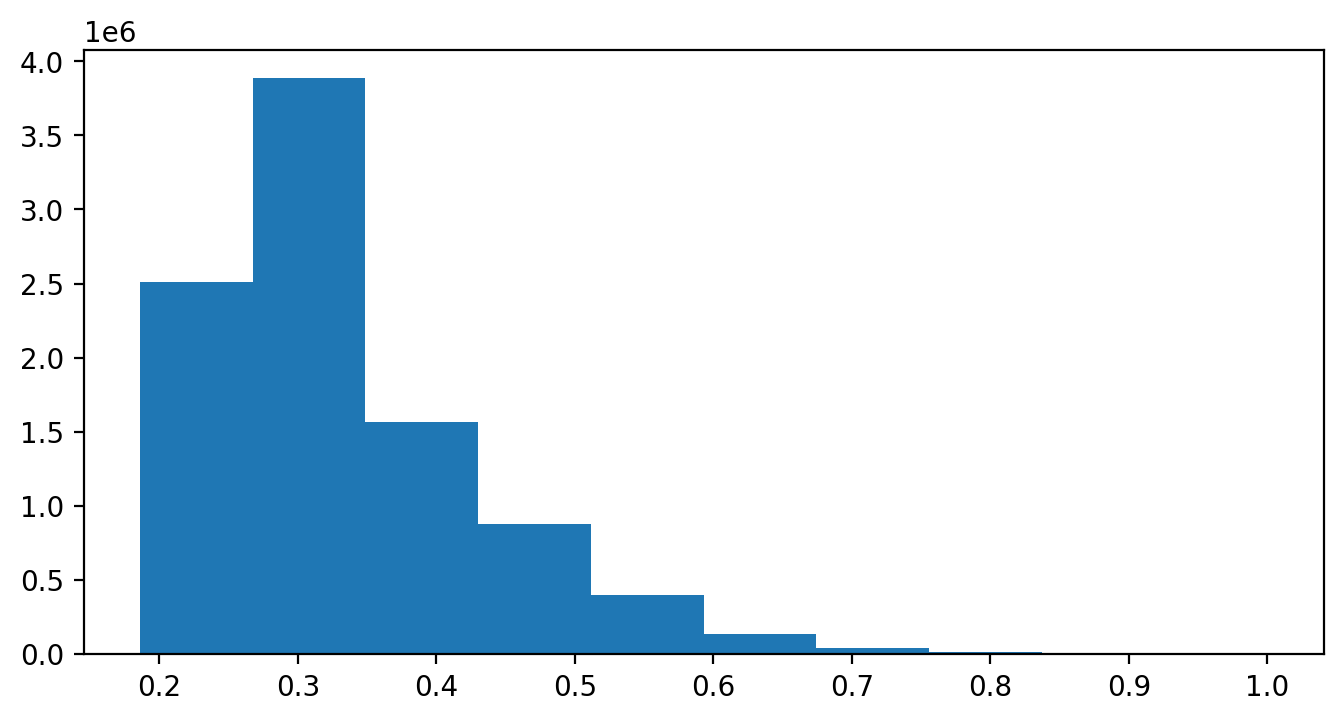

In [30]:
plt.hist(score)

In [31]:
q = np.quantile(score, 0.90)
q * 1000

471.0

In [32]:
np.quantile(score, 0.95) * 1000

527.0

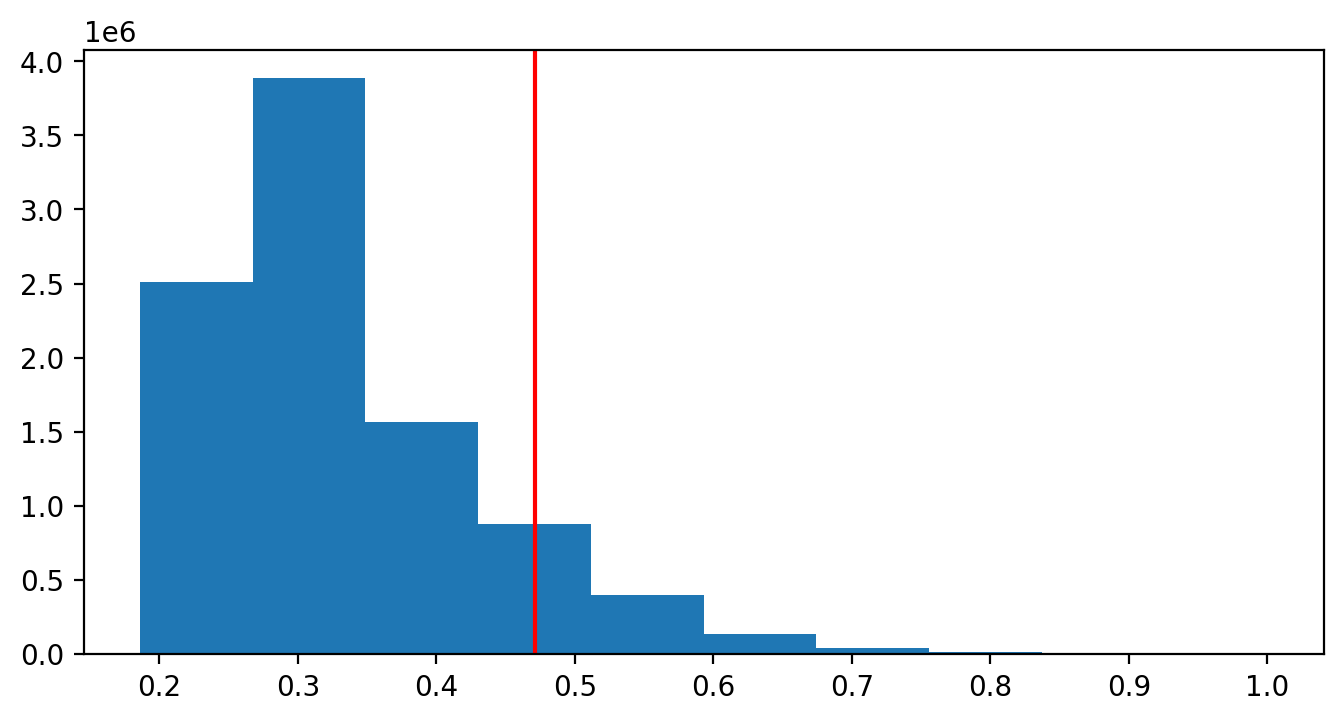

In [33]:
plt.hist(score)
plt.axvline(q, c='r')

In [34]:
q

0.471

In [35]:
d.loc[d.score > q].width.sum() / hg38_len, d.width.sum() / hg38_len

(0.01853522601369948, 0.050822503529791174)

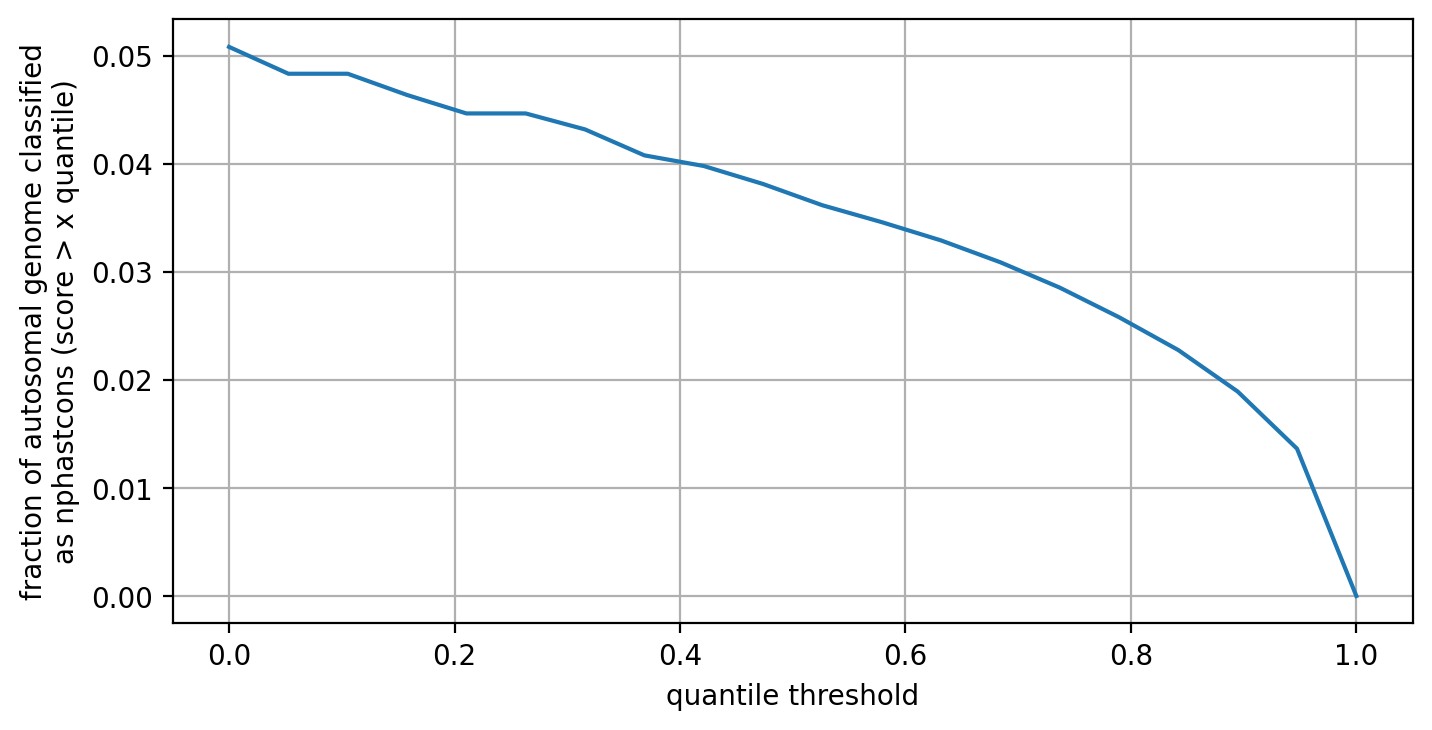

In [36]:
quants = np.linspace(0, 1, 20)

plt.plot(quants, [d.loc[d.score > np.quantile(d.score, q)].width.sum()/hg38_len for q in quants])
plt.ylabel('fraction of autosomal genome classified\nas nphastcons (score > x quantile)')
plt.xlabel('quantile threshold')
plt.grid()

In [37]:
np.quantile(score, (0, 0.5, 0.9, 0.95))*1000


array([186., 300., 471., 527.])

## CADD Scores

In [54]:
cadd = pd.read_csv('../data/annotation/cadd_chr1.tsv', sep='\t')

In [58]:
cadd.columns = ('chr', 'pos', 'ref', 'alt', 'score', 'phred')

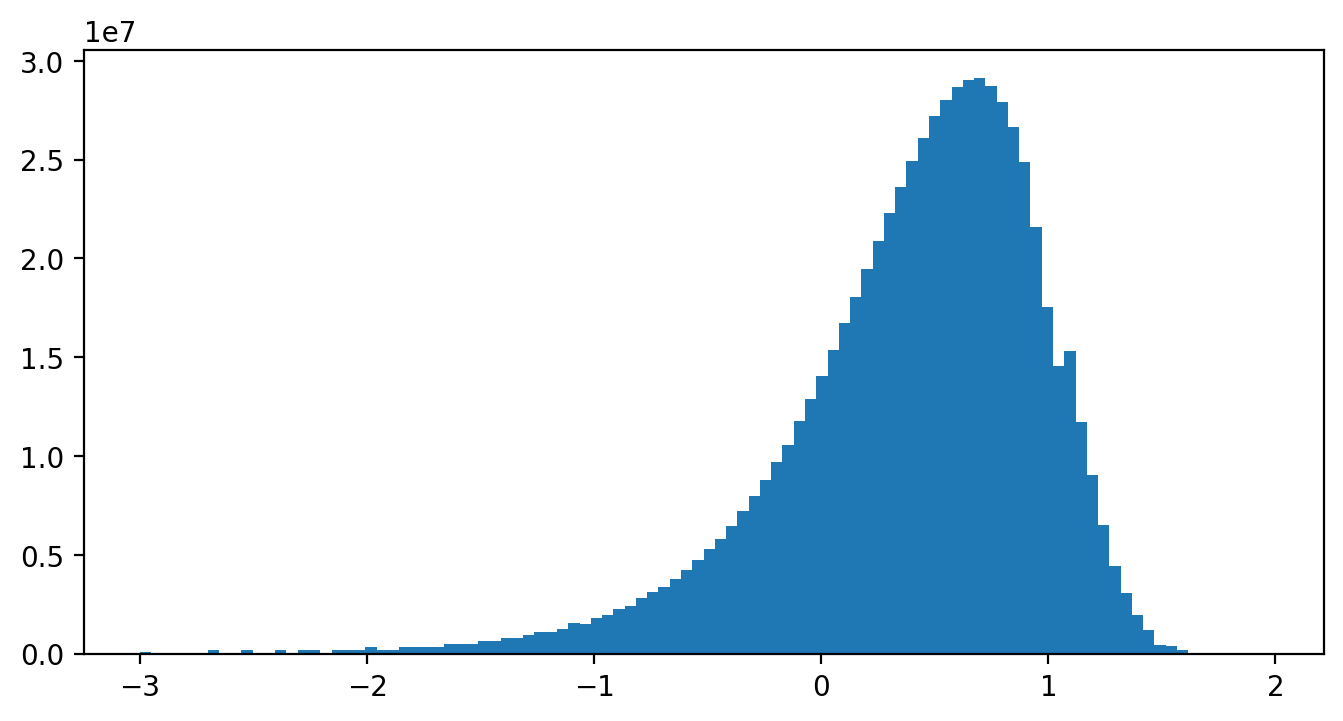

In [65]:
_ = plt.hist(np.log10(cadd.phred), 100)

In [70]:
idx = np.log10(cadd.phred) > 1.1

In [71]:
from bgspy.utils import masks_to_ranges

In [75]:
rngs = masks_to_ranges({'chr1': idx}, None)

NameError: name 'm' is not defined